## Ejercicios de pair programming 30 enero: Métricas

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

### Info columnas
|Column| Type | Description |
|-------|--------------|-------------|
|distance_from_home| float64|	The distance from home where the transaction happened
|distance_from_last_transaction| float64|	The distance from last transaction happened.
|ratio_to_median_purchase_price| float64|	Ratio of purchased price transaction to median purchase price.
|repeat_retailer| float64|	Is the transaction happened from same retailer. 
|used_chip| float64|	Is the transaction through chip (credit card)
|used_pin_number| float64|	Is the transaction happened by using PIN number. 
|online_order | float64| Is the transaction an online order.
|fraud | float64| Is the transaction fraudulent.   

Enlace del *DataFrame* *[card_transdata](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud)*

In [3]:
df = pd.read_csv("../datos/card_transdata_balanceado.csv", index_col = 0)
df.head(2)

,repeat_retailer,used_chip,used_pin_number,online_order,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,fraud
542808,1,0,0,1,0.40592,-0.193917,-0.266181,0
491334,1,1,1,0,-0.34529,2.426464,4.655666,0


In [5]:
# separamos los datos en X e y

X1 = df.drop("fraud", axis = 1)
y1 = df["fraud"]

In [6]:
# separamos en train y test
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [7]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

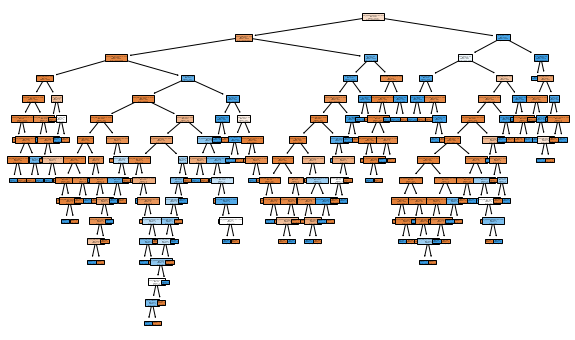

In [9]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train1.columns, filled = True)
plt.show()

In [8]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train1.columns))
max_features

2.6457513110645907

In [10]:
# max depth

print(arbol.tree_.max_depth)

15


In [11]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [12]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kappa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [13]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree I")
dt_results1

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.999911,0.999865,0.999925,0.999895,0.999818,test,Decission Tree I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree I


Podemos ver que nuestro modelo está overfitting por lo cual volvemos a hacer calculos para acercarnos a un modelo funcional.

In [14]:
param = {"max_depth": [2 ,4, 6, 8, 10], # teniendo en cuenta que teníamos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 15.
        "max_features": [1,2,3], # la raiz cuadrada es 2,6 por esto decidimos en tener 1,2,3.
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [15]:
gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), 
            param_grid= param, 
            cv=10, 
            verbose=-1) 


In [16]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

In [ ]:
mejor_modelo = gs.best_estimator_
mejor_modelo

In [ ]:
#fig = plt.figure(figsize=(40, 20))
#tree.plot_tree(mejor_modelo, feature_names=x_train1.columns, filled=True);

In [ ]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [ ]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision Tree II")
dt_results2

In [ ]:
# juntamos los dos modelos para compararlos.

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

In [ ]:
df_logistic_results = pd.read_csv("../files/../datos/resultados_fraude.csv", index_col = 0)
df_logistic_results


In [ ]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results

In [ ]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results